In [731]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
pd.set_option('display.max_columns', 100)

warnings.filterwarnings('ignore')

In [732]:
data = pd.read_csv('input/train.csv')

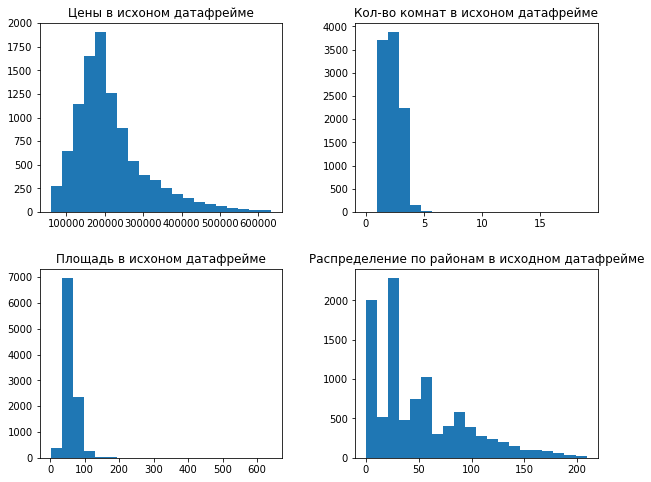

In [733]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].hist(data['Price'], bins=20)
ax[0, 1].hist(data['Rooms'], bins=20)
ax[1, 0].hist(data['Square'], bins=20)
ax[1, 1].hist(data['DistrictId'], bins=20)
ax[0, 0].set_title('Цены в исхоном датафрейме')
ax[0, 1].set_title('Кол-во комнат в исхоном датафрейме')
ax[1, 0].set_title('Площадь в исхоном датафрейме')
ax[1, 1].set_title('Распределение по районам в исходном датафрейме')
fig.set_size_inches(10, 8)
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.3)

### train_test_split

In [734]:
from sklearn.model_selection import train_test_split

In [735]:
train, valid = train_test_split(data, test_size=0.7, random_state=42)

### Prepare data

In [736]:
train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [737]:
train.shape

(3000, 20)

In [738]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 5525 to 7270
Data columns (total 20 columns):
Id               3000 non-null int64
DistrictId       3000 non-null int64
Rooms            3000 non-null float64
Square           3000 non-null float64
LifeSquare       2360 non-null float64
KitchenSquare    3000 non-null float64
Floor            3000 non-null int64
HouseFloor       3000 non-null float64
HouseYear        3000 non-null int64
Ecology_1        3000 non-null float64
Ecology_2        3000 non-null object
Ecology_3        3000 non-null object
Social_1         3000 non-null int64
Social_2         3000 non-null int64
Social_3         3000 non-null int64
Healthcare_1     1563 non-null float64
Helthcare_2      3000 non-null int64
Shops_1          3000 non-null int64
Shops_2          3000 non-null object
Price            3000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 492.2+ KB


In [739]:
def prepare_year(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2008
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

In [740]:
def prepare_rooms(df, source_df):
    df.loc[df['Rooms'] > 5, 'Rooms'] = source_df['Rooms'].median()
    return df

In [741]:
mean_square = train.groupby('Rooms', as_index=False)[['Square', 'LifeSquare']].mean().rename(columns={'Square': 'mean_square', 
                                                                                                          'LifeSquare': 'mean_lifesquare'})
def prepare_square(df, mean_square):
    small_square_ids = df.loc[df['Square'] < 15, 'Id'].values
    if ('mean_square' not in df.columns) & ('mean_lifesquare' not in df.columns):
        df = pd.merge(df, mean_square, on=['Rooms'], how='left')
    df.loc[df['Id'].isin(small_square_ids), 'Square'] = df['mean_square']
    large_square_ids = df.loc[df['Square'] > 150, 'Id'].values
    df.loc[df['Id'].isin(large_square_ids), 'Square'] = df['mean_square']
    df.loc[df['Id'].isin(large_square_ids), 'LifeSquare'] = df['mean_lifesquare']
    df['LifeSquare'] = df['LifeSquare'].fillna(df['mean_lifesquare'])
    df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] = df['Square']
    return df

In [742]:
def prepare_ecology(df):
    df['Ecology_2'] = (df['Ecology_2'] == 'B').astype(int)
    df['Ecology_3'] = (df['Ecology_3'] == 'B').astype(int)
    return df

In [743]:
def prepare_shops(df):
    df['Shops_2'] = (df['Shops_2'] == 'B').astype(int)
    return df

In [744]:
stat1 = train.groupby(['DistrictId', 'Rooms'], as_index=False)[['Price']].mean().rename(columns={'Price':'mean_price1'})
stat2 = train.groupby('Rooms', as_index=False)[['Price']].mean().rename(columns={'Price':'mean_price2'})
mean_price = train['Price'].mean()

In [745]:
def add_mean_price(df, stat1, stat2, mean_price):
    if ('mean_price1' not in df.columns) & ('mean_price2' not in df.columns):
        df = pd.merge(df, stat1, on=['DistrictId', 'Rooms'], how='left')
        df = pd.merge(df, stat2, on='Rooms', how='left')
        df['mean_price2'] = df['mean_price2'].fillna(mean_price)
        df['mean_price1'] = df['mean_price1'].fillna(df['mean_price2'])
    return df

In [746]:
distr_info1 = train['DistrictId'].value_counts(normalize=True).reset_index().rename(columns={'index':'DistrictId', 
                                                                               'DistrictId':'flat_qty_distr'})

In [748]:
def add_district_info(df, source_df=train):
    if ('flat_qty_distr' not in df.columns):
        distr_info = source_df['DistrictId'].value_counts(normalize=True).reset_index().rename(columns={'index':'DistrictId', 
                                                                               'DistrictId':'flat_qty_distr'})
        df = pd.merge(df, distr_info, on='DistrictId', how='left')
        df['flat_qty_distr'] = df['flat_qty_distr'].fillna(0.000143)
    return df

In [749]:
def prepare_data(df, source_df=train, stat1=stat1, stat2=stat2, mean_price=mean_price, mean_square=mean_square):
    if ('Healthcare_1' in df.columns):
        df = df.drop('Healthcare_1', axis=1)
    df = prepare_year(df)
    df = prepare_rooms(df, source_df)
    df = prepare_square(df, mean_square)
    df = prepare_ecology(df)
    df = prepare_shops(df)
    df = add_mean_price(df, stat1, stat2, mean_price)
    df = add_district_info(df, source_df)
    return df

In [750]:
train = prepare_data(train)

In [751]:
valid = prepare_data(valid)

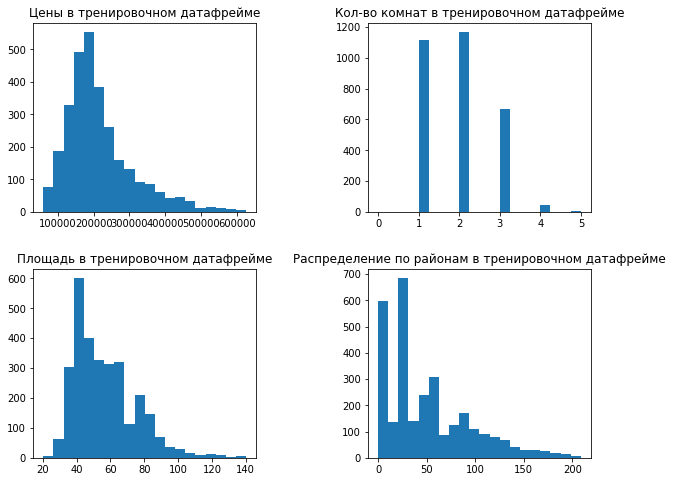

In [752]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].hist(train['Price'], bins=20)
ax[0, 1].hist(train['Rooms'], bins=20)
ax[1, 0].hist(train['Square'], bins=20)
ax[1, 1].hist(train['DistrictId'], bins=20)
ax[0, 0].set_title('Цены в тренировочном датафрейме')
ax[0, 1].set_title('Кол-во комнат в тренировочном датафрейме')
ax[1, 0].set_title('Площадь в тренировочном датафрейме')
ax[1, 1].set_title('Распределение по районам в тренировочном датафрейме')
fig.set_size_inches(10, 8)
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.3)

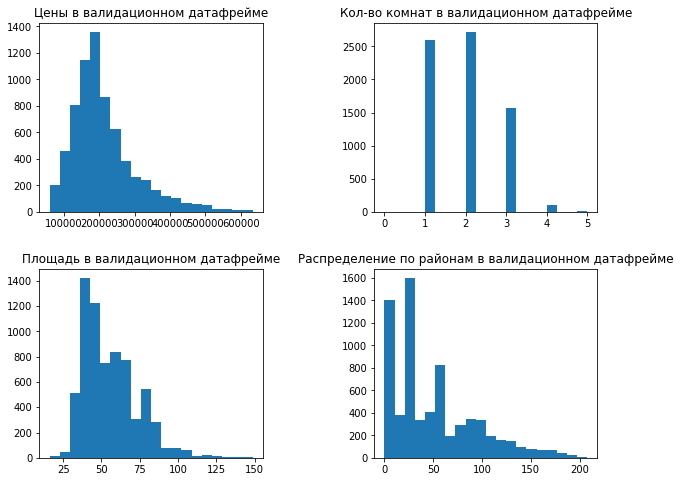

In [753]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].hist(valid['Price'], bins=20)
ax[0, 1].hist(valid['Rooms'], bins=20)
ax[1, 0].hist(valid['Square'], bins=20)
ax[1, 1].hist(valid['DistrictId'], bins=20)
ax[0, 0].set_title('Цены в валидационном датафрейме')
ax[0, 1].set_title('Кол-во комнат в валидационном датафрейме')
ax[1, 0].set_title('Площадь в валидационном датафрейме')
ax[1, 1].set_title('Распределение по районам в валидационном датафрейме')
fig.set_size_inches(10, 8)
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.3)

### Model

In [754]:
from sklearn.ensemble import RandomForestRegressor as RF

In [755]:
model = RF(n_estimators=6, max_depth=9, random_state=42)

In [756]:
feats = ['Rooms', 'Square', 'KitchenSquare', 'HouseYear', 'mean_price1']

In [762]:
feats = ['DistrictId', 'Rooms', 'Square', 'Floor', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1',
       'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'flat_qty_distr']

In [776]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,mean_square,mean_lifesquare,mean_price1,mean_price2,flat_qty_distr
0,10421,46,2.0,45.989112,28.585711,5.0,4,5.0,1963,0.188784,1,1,31,6137,4,0,1,1,198274.384595,56.812247,35.384694,230882.721507,216934.825271,0.014667
1,13111,55,1.0,40.570752,19.719605,8.0,2,17.0,1992,0.041365,1,1,31,5569,0,1,4,1,149593.023848,41.442817,25.476403,163679.057284,159958.953544,0.005333
2,8349,6,1.0,40.081713,25.476403,1.0,3,1.0,1977,0.243205,1,1,5,1564,0,0,0,1,118035.159516,41.442817,25.476403,133491.711344,159958.953544,0.049000
3,15368,57,2.0,55.681838,32.825366,9.0,12,14.0,2003,0.090799,1,1,74,19083,2,5,15,1,226109.027544,56.812247,35.384694,259630.863583,216934.825271,0.009333
4,12179,75,2.0,46.222166,31.494145,5.0,6,5.0,1962,0.307467,1,0,30,5048,9,2,5,1,168429.892158,56.812247,35.384694,207888.773859,216934.825271,0.005000


In [764]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [765]:
from sklearn.metrics import r2_score as r2

In [766]:
def evaluate_model(df, model=model, feats=feats, check_r2='Yes'):
    pred = model.predict(df.loc[:, feats])
    if check_r2 == 'Yes':
        r2_ = r2(df['Price'], pred)
        print('R2: {}'.format(r2_))
    return pred

In [767]:
pred_train = evaluate_model(train)

R2: 0.8616616108642822


In [768]:
pred_valid = evaluate_model(valid)

R2: 0.6657653476430301


#### Модель Random Forest с кросс-валидацией

In [769]:
from sklearn.model_selection import GridSearchCV

In [787]:
parameters = [{'n_estimators': [150, 200, 250], 
               'max_features': np.arange(5, 6),
               'max_depth': np.arange(10, 11)}]

In [788]:
clf = GridSearchCV(estimator=RF(random_state=100), 
                   param_grid=parameters,
                   cv=5)

In [789]:
clf.fit(train.loc[:, feats], train['Price'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [150, 200, 250], 'max_features': array([5]), 'max_depth': array([10])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [790]:
clf.best_params_

{'max_depth': 10, 'max_features': 5, 'n_estimators': 200}

In [791]:
pred_train = evaluate_model(train, clf)

R2: 0.8891472196067308


In [792]:
pred_train = evaluate_model(valid, clf)

R2: 0.6985022814408708


### Test

In [800]:
test = pd.read_csv('input/test.csv')

In [801]:
test = prepare_data(test)

In [802]:
test['Price'] = evaluate_model(test, clf, check_r2='No')

In [803]:
test.loc[:, ['Id', 'Price']].to_csv('VKulikov_predictions.csv', index=None)